In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
cd gdrive/My Drive/Colab/Project

/content/gdrive/My Drive/Colab/Project


In [0]:
pwd

'/content/gdrive/My Drive/Colab/Project'

In [0]:
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import glob
import cv2 as cv
import time
import copy as cp
import pandas as pd
import pickle 
import time

import torch
from torch.utils import data
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import warnings
warnings.filterwarnings("ignore")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


In [0]:
def load1(path_train,path_test1,path_test2):
    transform = transforms.Compose([transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    batch_size=32
    
    trainloader = torch.utils.data.DataLoader(
          ImageFilelist(root=path_train,lbl='Training', 
          transform=transform),
          batch_size=batch_size, shuffle=True, pin_memory=True)
    
    testloader1 = torch.utils.data.DataLoader(
          ImageFilelist(root=path_test1,lbl='PublicTest',
          transform=transform),
          batch_size=batch_size, shuffle=True, pin_memory=True)

    testloader2 = torch.utils.data.DataLoader(
          ImageFilelist(root=path_test2,lbl='PrivateTest',
          transform=transform),
          batch_size=batch_size, shuffle=True, pin_memory=True)

          
    return trainloader,testloader1,testloader2


In [0]:
def train(trainloader,net):
    trn=[]; lbl=[]; c=0; t=time.time()
    with torch.no_grad():
         for data1 in trainloader:
             c+=1
             if(c%100==0):
                 print('Training: ',c,', Time: ',time.time()-t)
                 t=time.time()
             images, labels = data1
             images, labels = torch.tensor(images), torch.tensor(labels)
             images, labels = images.to(device), labels.to(device)
             out = net(images)
             for outputs in out:
                trn.append(cp.deepcopy(np.array(outputs.cpu(),np.double)))
             for label in labels:
                lbl.append(cp.deepcopy(np.array(label.cpu(),np.int32)))
    return np.array(trn),np.array(lbl)
         
    
def test(testloader,net):
    tst=[]; lbl=[]; c=0; t=time.time()
    with torch.no_grad():
         for data1 in testloader:
             c+=1
             if(c%50==0):
                 print('Testing: ',c,', Time: ',time.time()-t)
                 t=time.time()
             images, labels = data1
             images, labels = torch.tensor(images), torch.tensor(labels)
             images, labels = images.to(device), labels.to(device)
             out = net(images)
             for outputs in out:  
                tst.append(cp.deepcopy(np.array(outputs.cpu(),np.double)))
             for label in labels:
               lbl.append(cp.deepcopy(np.array(label.cpu(),np.int32)))
    return np.array(tst),np.array(lbl)

In [0]:
 def default_flist_reader(flist,lbl):
    imlist=[]
    path='fer2013.csv'
    data=pd.read_csv(path)
    emotion={0:'Angry',1:'Disgust',2:'Fear',3:'Happy',4:'Sad', 5:'Surprise', 6:'Neutral'}
    for i in range(len(data.pixels)):
        if(lbl==data.Usage[i]):
          im=np.array(data.pixels[i].split(' '),np.uint8)
          im.shape=(48,48)
          im=Image.fromarray(im).convert('RGB')
          nm=data.emotion[i]
          imlist.append(cp.deepcopy((im,nm)))    
    print(len(imlist))
    return imlist
   
class ImageFilelist(data.Dataset):
     def __init__(self, root, transform=None,lbl='Training', target_transform=None,
         flist_reader=default_flist_reader):
         self.lbl=lbl
         self.imlist = flist_reader(root,lbl)
         self.transform = transform
         self.target_transform = target_transform
         
   
     def __getitem__(self, index):
         img, target = self.imlist[index]
         #img = self.loader(impath)
         if self.transform is not None:
            img = self.transform(img)
         if self.target_transform is not None:
            target = self.target_transform(target)
         return img, target
   
     def __len__(self):
         return len(self.imlist)


In [0]:
p_trn='/Training/'
p_tst1='/PublicTest/'
p_tst2='/PrivateTest/'
trainloader,testloader1,testloader2=load1(p_trn,p_tst1,p_tst2)

28709
3589
3589


In [0]:
def test(testloader):
  correct = 0
  total = 0
  #L=[]; P=[]
  with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels=images.to(device), labels.to(device)
        outputs = net(images)
        #for i in labels:
        #  L.append(numpy.array(i.cpu()))
        _, predicted = torch.max(outputs.data, 1)
        #for i in predicted:
        #   P.append(numpy.array(i.cpu()))
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
  
  return 100 * (correct / total)

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 8, 5)
        self.conv3 = nn.Conv2d(8, 12, 7)
        self.conv4 = nn.Conv2d(12, 16, 3)
        self.conv5 = nn.Conv2d(16, 32, 5)
        self.conv6 = nn.Conv2d(32, 64, 7)
        self.fc1 = nn.Linear(7*7*64, 800)
        self.fc2 = nn.Linear(800, 140)
        self.fc3 = nn.Linear(140, 7)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.pool(F.relu(self.conv4(x)))
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = x.view(-1,64*7*7)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 8, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(8, 12, kernel_size=(7, 7), stride=(1, 1))
  (conv4): Conv2d(12, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv6): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1))
  (fc1): Linear(in_features=3136, out_features=800, bias=True)
  (fc2): Linear(in_features=800, out_features=140, bias=True)
  (fc3): Linear(in_features=140, out_features=7, bias=True)
)

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [0]:
x=[]; y1=[]; y2=[]; er=[]
for epoch in range(1000):  
    running_loss = 0.0
    counter=0
    for i, data in enumerate(trainloader, 0):
        counter+=1
        inputs, labels = data
        inputs, labels =inputs.to(device), labels.to(device) 
        optimizer.zero_grad()

        outputs = net(inputs)
        #print(outputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()    
    acc_pub=test(testloader1)
    acc_pri=test(testloader2)
    print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss),' | Accuracy--  val: %0.2f'%(acc_pub),' | test: %0.2f'%(acc_pri))
    y1.append(acc_pub)
    y2.append(acc_pri)
    x.append(epoch)
    er.append(running_loss)
    if(epoch % 25 ==0):
      torch.save({
            'epoch': epoch,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': running_loss,
            }, '/hello')

[1,   898] loss: 3.012  | Accuracy--  val: 49.62  | test: 50.24
[2,   898] loss: 3.006  | Accuracy--  val: 49.62  | test: 50.26
[3,   898] loss: 2.997  | Accuracy--  val: 49.71  | test: 50.15
[4,   898] loss: 3.035  | Accuracy--  val: 49.60  | test: 50.26
[5,   898] loss: 3.041  | Accuracy--  val: 49.62  | test: 50.15
[6,   898] loss: 3.029  | Accuracy--  val: 49.60  | test: 50.15
[7,   898] loss: 3.004  | Accuracy--  val: 49.62  | test: 50.13
[8,   898] loss: 3.005  | Accuracy--  val: 49.62  | test: 50.18
[9,   898] loss: 3.019  | Accuracy--  val: 49.51  | test: 50.18
[10,   898] loss: 3.007  | Accuracy--  val: 49.48  | test: 50.15
[11,   898] loss: 3.007  | Accuracy--  val: 49.57  | test: 50.15
[12,   898] loss: 3.001  | Accuracy--  val: 49.37  | test: 50.29
[13,   898] loss: 3.009  | Accuracy--  val: 49.57  | test: 50.26


KeyboardInterrupt: ignored

Text(0.5, 1.0, 'Training Error plot')

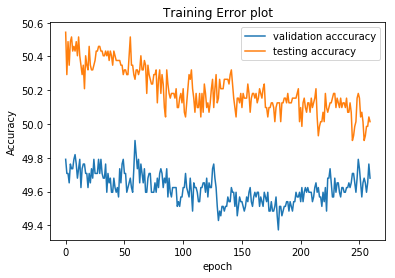

In [0]:
plt.plot(x,y1,label='validation acccuracy')
plt.plot(x,y2,label='testing accuracy')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training Error plot')

Text(0, 0.5, 'Cross Entropy Loss')

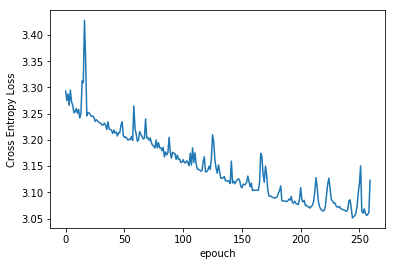

In [0]:
plt.plot(x,er)
plt.xlabel('epouch')
plt.ylabel('Cross Entropy Loss')

In [0]:
torch.save(net,'/hello')

In [0]:
import pickle
with open("net9_1.pickle", "wb") as output_file:
     pickle.dump(net, output_file)

In [0]:
pwd

'/content/gdrive/My Drive/Colab/Project'

In [0]:
 torch.save({
            'epoch': epoch,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': running_loss,
            }, '/hello')
      

**References**

In [0]:
[1] https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html
[2] https://pytorch.org/docs/stable/torchvision/models.html
[3] https://pytorch.org/docs/stable/data.html
[4] https://github.com/pytorch/vision/issues/81